# Sign Language Recognition with CNN+LSTM

This notebook trains a CNN+LSTM model for sign language recognition using the hand ROIs extracted from the previous notebook.

## Workflow Overview:
1. **Load Data**: Load extracted hand ROIs and organize them as sequences
2. **Prepare Dataset**: Create PyTorch datasets and dataloaders
3. **Build Model**: Create a CNN+LSTM architecture
4. **Train Model**: Train the model on the hand ROI sequences
5. **Test with Webcam**: Real-time sign language recognition using your camera

---

## 1. Install and Import Required Libraries

In [11]:
# Install required packages (uncomment if needed)
# !pip install torch torchvision opencv-python mediapipe numpy matplotlib scikit-learn

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

import cv2
import mediapipe as mp
import numpy as np
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
from collections import Counter

print("✓ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

✓ All libraries imported successfully!
PyTorch version: 2.9.0+cu130
CUDA available: True
CUDA device: NVIDIA GeForce RTX 3060 Laptop GPU


## 2. Configuration and Path Setup

In [3]:
# Path configurations
BASE_DIR = Path(r'c:\Users\shifttech\Desktop\Univ_M\AV\Tp\sign_Lang')
DATA_DIR = BASE_DIR / 'data' / 'compressed videos'
VIDEOS_DIR = DATA_DIR
OUTPUT_DIR = BASE_DIR / 'output'  # Output from previous notebook
MODEL_DIR = OUTPUT_DIR / 'model'
MODEL_DIR.mkdir(exist_ok=True)

# Model configurations
SEQUENCE_LENGTH = 30  # Number of frames per sequence
IMG_SIZE = 128  # Size to resize hand ROIs
BATCH_SIZE = 8
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
HIDDEN_SIZE = 256  # LSTM hidden size
NUM_LSTM_LAYERS = 2
DROPOUT = 0.5

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"✓ Configuration complete!")
print(f"  - Data directory: {DATA_DIR}")
print(f"  - Videos directory: {VIDEOS_DIR}")
print(f"  - Output directory: {OUTPUT_DIR}")
print(f"  - Model directory: {MODEL_DIR}")
print(f"  - Device: {device}")
print(f"  - Sequence length: {SEQUENCE_LENGTH} frames")
print(f"  - Image size: {IMG_SIZE}x{IMG_SIZE}")

✓ Configuration complete!
  - Data directory: c:\Users\shifttech\Desktop\Univ_M\AV\Tp\sign_Lang\data\compressed videos
  - Videos directory: c:\Users\shifttech\Desktop\Univ_M\AV\Tp\sign_Lang\data\compressed videos
  - Output directory: c:\Users\shifttech\Desktop\Univ_M\AV\Tp\sign_Lang\output
  - Model directory: c:\Users\shifttech\Desktop\Univ_M\AV\Tp\sign_Lang\output\model
  - Device: cuda
  - Sequence length: 30 frames
  - Image size: 128x128


## 3. Load and Prepare Dataset

Load the extracted hand ROI sequences from the previous notebook's output.

In [5]:
def load_video_sequences_from_folders(output_dir: Path, sequence_length: int = 30) -> Tuple[List, List, Dict]:
    """
    Load video sequences and their labels from the output directory.
    Works with folder-based structure where folders contain hand ROI files.
    
    Args:
        output_dir: Directory containing extracted hand ROIs
        sequence_length: Number of frames per sequence
    
    Returns:
        Tuple of (sequences, labels, word_counts)
    """
    print(f"Loading hand ROI sequences from {output_dir}...")
    
    sequences = []
    labels = []
    
    # Iterate through video directories in output
    video_dirs = [d for d in output_dir.iterdir() if d.is_dir() and d.name != 'model']
    
    print(f"\nFound {len(video_dirs)} video directories in {output_dir}")
    
    if len(video_dirs) == 0:
        print(f"⚠ WARNING: No video directories found in {output_dir}")
        print(f"  Please run the 'Hand_Detection_ROI_Extraction.ipynb' notebook first!")
        return sequences, labels, {}
    
    videos_without_rois = 0
    videos_with_rois = 0
    word_counts = Counter()
    
    for video_dir in tqdm(video_dirs, desc="Loading videos"):
        # Extract word from folder name (format: word_videofilename)
        folder_name = video_dir.name
        
        # Try to extract word from folder name
        parts = folder_name.split('_')
        
        # For folder structure like: baby/video1.mp4 -> output: baby_video1
        # We want to extract 'baby' as the word
        word = parts[0] if len(parts) > 0 else folder_name
        
        # Get all hand ROI files (not the full frames)
        roi_files = sorted([f for f in video_dir.glob('*_hand_0.jpg')])  # Use first hand only
        
        if len(roi_files) == 0:
            videos_without_rois += 1
            continue
        
        videos_with_rois += 1
        word_counts[word] += 1
        
        if len(roi_files) < sequence_length:
            # If not enough frames, pad with repetition of last frame
            roi_files = roi_files + [roi_files[-1]] * (sequence_length - len(roi_files))
        
        # Take fixed-length sequences with overlap
        for i in range(0, len(roi_files) - sequence_length + 1, sequence_length // 2):
            sequence_files = roi_files[i:i + sequence_length]
            if len(sequence_files) == sequence_length:
                sequences.append((sequence_files, video_dir))
                labels.append(word)
    
    print(f"\n✓ Processing complete:")
    print(f"  - Videos with hand ROIs: {videos_with_rois}")
    print(f"  - Videos without hand ROIs: {videos_without_rois}")
    print(f"  - Total sequences loaded: {len(sequences)}")
    print(f"  - Number of unique words: {len(set(labels))}")
    print(f"  - Words found: {sorted(list(set(labels)))}")
    print(f"  - Videos per word: {dict(word_counts)}")
    print(f"  - Class distribution: {Counter(labels)}")
    
    if len(sequences) == 0:
        print(f"\n⚠ ERROR: No sequences were loaded!")
        print(f"  This likely means no hand ROI files (*_hand_0.jpg) were found.")
        print(f"  Please check:")
        print(f"  1. Did you run 'Hand_Detection_ROI_Extraction.ipynb'?")
        print(f"  2. Did it successfully detect hands and save ROIs?")
        print(f"  3. Check the output directory: {output_dir}")
    
    return sequences, labels, word_counts


# Load sequences using the new function
sequences, labels, word_counts = load_video_sequences_from_folders(OUTPUT_DIR, SEQUENCE_LENGTH)

# Create label mapping (word to index)
unique_labels = sorted(list(set(labels)))
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}
NUM_CLASSES = len(unique_labels)

print(f"\n✓ Number of classes (words): {NUM_CLASSES}")
print(f"  - Words: {unique_labels}")
print(f"\n✓ Label to index mapping created")
if NUM_CLASSES > 0:
    print(f"  - Mapping: {label_to_idx}")

Loading hand ROI sequences from c:\Users\shifttech\Desktop\Univ_M\AV\Tp\sign_Lang\output...

Found 4002 video directories in c:\Users\shifttech\Desktop\Univ_M\AV\Tp\sign_Lang\output


Loading videos: 100%|██████████| 4002/4002 [00:13<00:00, 295.37it/s]


✓ Processing complete:
  - Videos with hand ROIs: 4000
  - Videos without hand ROIs: 2
  - Total sequences loaded: 11962
  - Number of unique words: 20
  - Words found: ['baby', 'eat', 'father', 'finish', 'good', 'happy', 'hear', 'house', 'important', 'love', 'mall', 'me', 'mosque', 'mother', 'normal', 'sad', 'stop', 'thanks', 'thinking', 'worry']
  - Videos per word: {'baby': 200, 'eat': 200, 'father': 200, 'finish': 200, 'good': 200, 'happy': 200, 'hear': 200, 'house': 200, 'important': 200, 'love': 200, 'mall': 200, 'me': 200, 'mosque': 200, 'mother': 200, 'normal': 200, 'sad': 200, 'stop': 200, 'thanks': 200, 'thinking': 200, 'worry': 200}
  - Class distribution: Counter({'baby': 771, 'sad': 756, 'mall': 755, 'normal': 695, 'worry': 678, 'thinking': 663, 'mosque': 641, 'important': 617, 'hear': 616, 'happy': 596, 'father': 591, 'mother': 557, 'thanks': 549, 'me': 547, 'love': 539, 'eat': 500, 'house': 484, 'good': 482, 'finish': 468, 'stop': 457})

✓ Number of classes (words): 20


## 4. Create PyTorch Dataset and DataLoader

## 4a. Diagnostic Check (Run this if you encounter errors)

If you're getting errors about no sequences found, run this cell to diagnose the issue.

In [6]:
# Diagnostic: Check output directory structure
print("=" * 60)
print("DIAGNOSTIC CHECK")
print("=" * 60)

print(f"\n1. Checking output directory: {OUTPUT_DIR}")
print(f"   Exists: {OUTPUT_DIR.exists()}")

if OUTPUT_DIR.exists():
    # List all subdirectories
    subdirs = [d for d in OUTPUT_DIR.iterdir() if d.is_dir() and d.name != 'model']
    print(f"\n2. Found {len(subdirs)} video directories (excluding 'model'):")
    
    if len(subdirs) > 0:
        for i, subdir in enumerate(subdirs[:5]):  # Show first 5
            print(f"   - {subdir.name}")
            
            # Check what files are in this directory
            all_files = list(subdir.glob('*'))
            jpg_files = list(subdir.glob('*.jpg'))
            hand_files = list(subdir.glob('*_hand_*.jpg'))
            
            print(f"     Total files: {len(all_files)}")
            print(f"     JPG files: {len(jpg_files)}")
            print(f"     Hand ROI files (*_hand_*.jpg): {len(hand_files)}")
            
            if len(hand_files) > 0:
                print(f"     Sample files: {[f.name for f in hand_files[:3]]}")
        
        if len(subdirs) > 5:
            print(f"   ... and {len(subdirs) - 5} more directories")
    else:
        print("   ⚠ No video directories found!")
        print("   This means the first notebook hasn't been run yet.")
else:
    print("   ⚠ Output directory doesn't exist!")
    print("   Please run 'Hand_Detection_ROI_Extraction.ipynb' first")

print("\n3. Recommendation:")
if not OUTPUT_DIR.exists() or len(subdirs) == 0:
    print("   ❌ You MUST run the 'Hand_Detection_ROI_Extraction.ipynb' notebook first!")
    print("      This notebook processes videos and extracts hand ROIs.")
    print("      Without that data, this training notebook cannot work.")
else:
    # Check if any directories have hand ROI files
    dirs_with_rois = sum(1 for d in subdirs if len(list(d.glob('*_hand_0.jpg'))) > 0)
    print(f"   Directories with hand ROI files: {dirs_with_rois}/{len(subdirs)}")
    
    if dirs_with_rois == 0:
        print("   ❌ No hand ROI files found in any directory!")
        print("      The first notebook may have run but didn't detect/save hands.")
        print("      Check if 'visualize=True' was set in the first notebook.")
    elif dirs_with_rois < len(subdirs):
        print(f"   ⚠ Only {dirs_with_rois} out of {len(subdirs)} videos have hand ROIs.")
        print("      Some videos may not have detected hands.")
        print("      This is normal, but you need more videos with successful detection.")
    else:
        print(f"   ✅ All {dirs_with_rois} videos have hand ROI files!")
        print("      The issue might be with class distribution or filtering.")

print("=" * 60)

DIAGNOSTIC CHECK

1. Checking output directory: c:\Users\shifttech\Desktop\Univ_M\AV\Tp\sign_Lang\output
   Exists: True

2. Found 4002 video directories (excluding 'model'):
   - baby_0
     Total files: 107
     JPG files: 107
     Hand ROI files (*_hand_*.jpg): 99
     Sample files: ['frame_0016_hand_0.jpg', 'frame_0017_hand_0.jpg', 'frame_0018_hand_0.jpg']
   - baby_1
     Total files: 117
     JPG files: 117
     Hand ROI files (*_hand_*.jpg): 105
     Sample files: ['frame_0041_hand_0.jpg', 'frame_0044_hand_0.jpg', 'frame_0045_hand_0.jpg']
   - baby_10
     Total files: 221
     JPG files: 221
     Hand ROI files (*_hand_*.jpg): 210
     Sample files: ['frame_0000_hand_0.jpg', 'frame_0000_hand_1.jpg', 'frame_0001_hand_0.jpg']
   - baby_100
     Total files: 81
     JPG files: 81
     Hand ROI files (*_hand_*.jpg): 73
     Sample files: ['frame_0004_hand_0.jpg', 'frame_0009_hand_0.jpg', 'frame_0010_hand_0.jpg']
   - baby_101
     Total files: 110
     JPG files: 110
     Hand ROI 

In [7]:
class SignLanguageDataset(Dataset):
    """
    PyTorch Dataset for sign language sequences.
    """
    
    def __init__(self, sequences, labels, label_to_idx, img_size=128, transform=None):
        """
        Args:
            sequences: List of (frame_files, video_dir) tuples
            labels: List of action labels
            label_to_idx: Dictionary mapping labels to indices
            img_size: Size to resize images
            transform: Optional transform to apply
        """
        self.sequences = sequences
        self.labels = labels
        self.label_to_idx = label_to_idx
        self.img_size = img_size
        self.transform = transform
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence_files, video_dir = self.sequences[idx]
        label = self.labels[idx]
        label_idx = self.label_to_idx[label]
        
        # Load all frames in sequence
        frames = []
        for frame_file in sequence_files:
            # Read image
            img = cv2.imread(str(frame_file))
            
            if img is None:
                # Use black image if file cannot be read
                img = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)
            else:
                # Convert BGR to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # Resize
                img = cv2.resize(img, (self.img_size, self.img_size))
            
            # Normalize to [0, 1]
            img = img.astype(np.float32) / 255.0
            
            # Apply transform if provided
            if self.transform:
                img = self.transform(img)
            else:
                # Convert to tensor (H, W, C) -> (C, H, W)
                img = torch.from_numpy(img).permute(2, 0, 1)
            
            frames.append(img)
        
        # Stack frames into sequence tensor (T, C, H, W)
        sequence_tensor = torch.stack(frames)
        
        return sequence_tensor, label_idx


# Check if we have any sequences
if len(sequences) == 0:
    print("\n" + "="*60)
    print("⚠ ERROR: NO SEQUENCES FOUND!")
    print("="*60)
    print("Possible reasons:")
    print("1. The first notebook hasn't been run yet")
    print("2. No hand ROI files were generated in the output directory")
    print("3. The output directory path is incorrect")
    print(f"\nExpected path: {OUTPUT_DIR}")
    print(f"Directory exists: {OUTPUT_DIR.exists()}")
    if OUTPUT_DIR.exists():
        subdirs = [d.name for d in OUTPUT_DIR.iterdir() if d.is_dir()]
        print(f"Found {len(subdirs)} subdirectories: {subdirs[:5]}...")
    print("\n⚠ Please run the 'Hand_Detection_ROI_Extraction.ipynb' notebook first!")
    print("="*60)
    raise ValueError("No sequences loaded. Please run the hand detection notebook first.")

# Filter out classes with too few samples (need at least 2 for train/val split)
label_counts = Counter(labels)
print(f"\nLabel distribution: {label_counts}")

# Keep only classes with at least 2 samples
valid_indices = [i for i, label in enumerate(labels) if label_counts[label] >= 2]
filtered_sequences = [sequences[i] for i in valid_indices]
filtered_labels = [labels[i] for i in valid_indices]

print(f"\nFiltered out {len(sequences) - len(filtered_sequences)} sequences from classes with <2 samples")
print(f"Remaining sequences: {len(filtered_sequences)}")

# Check if we have enough data after filtering
if len(filtered_sequences) < 2:
    print("\n" + "="*60)
    print("⚠ ERROR: NOT ENOUGH DATA!")
    print("="*60)
    print(f"Only {len(filtered_sequences)} sequences remain after filtering.")
    print("Need at least 2 sequences to create train/val split.")
    print("\nSuggestions:")
    print("1. Run the first notebook to process more videos")
    print("2. Lower MIN_VIDEOS_PER_WORD in the first notebook")
    print("3. Ensure hand detection is working properly")
    print("="*60)
    raise ValueError("Insufficient data for training. Need at least 2 sequences.")

# Split into train and validation sets
# Use stratify only if all classes have at least 2 samples
try:
    train_sequences, val_sequences, train_labels, val_labels = train_test_split(
        filtered_sequences, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
    )
    print(f"✓ Using stratified split")
except ValueError as e:
    # If still issues, split without stratification
    print(f"⚠ Warning: Cannot use stratified split ({e})")
    print("  Using random split instead.")
    train_sequences, val_sequences, train_labels, val_labels = train_test_split(
        filtered_sequences, filtered_labels, test_size=0.2, random_state=42, shuffle=True
    )

print(f"\n✓ Dataset split:")
print(f"  - Training samples: {len(train_sequences)}")
print(f"  - Validation samples: {len(val_sequences)}")

# Create datasets
train_dataset = SignLanguageDataset(train_sequences, train_labels, label_to_idx, IMG_SIZE)
val_dataset = SignLanguageDataset(val_sequences, val_labels, label_to_idx, IMG_SIZE)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\n✓ DataLoaders created:")
print(f"  - Training batches: {len(train_loader)}")
print(f"  - Validation batches: {len(val_loader)}")


Label distribution: Counter({'baby': 771, 'sad': 756, 'mall': 755, 'normal': 695, 'worry': 678, 'thinking': 663, 'mosque': 641, 'important': 617, 'hear': 616, 'happy': 596, 'father': 591, 'mother': 557, 'thanks': 549, 'me': 547, 'love': 539, 'eat': 500, 'house': 484, 'good': 482, 'finish': 468, 'stop': 457})

Filtered out 0 sequences from classes with <2 samples
Remaining sequences: 11962
✓ Using stratified split

✓ Dataset split:
  - Training samples: 9569
  - Validation samples: 2393

✓ DataLoaders created:
  - Training batches: 1197
  - Validation batches: 300


## 5. Build CNN+LSTM Model

Create a hybrid architecture:
- **CNN (ResNet18)**: Extracts spatial features from each frame
- **LSTM**: Captures temporal dependencies across frames

In [8]:
class CNN_LSTM_Model(nn.Module):
    """
    CNN+LSTM model for sign language recognition.
    
    Architecture:
    1. CNN (ResNet18) extracts features from each frame
    2. LSTM processes the sequence of CNN features
    3. Fully connected layers for classification
    """
    
    def __init__(self, num_classes, hidden_size=256, num_lstm_layers=2, dropout=0.5):
        super(CNN_LSTM_Model, self).__init__()
        
        # CNN Feature Extractor (ResNet18 pretrained on ImageNet)
        resnet = models.resnet18(pretrained=True)
        # Remove the final fully connected layer
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])
        self.cnn_output_size = 512  # ResNet18 outputs 512 features
        
        # Freeze early CNN layers (optional - can unfreeze for fine-tuning)
        for param in list(self.cnn.parameters())[:-10]:
            param.requires_grad = False
        
        # LSTM for temporal modeling
        self.lstm = nn.LSTM(
            input_size=self.cnn_output_size,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: Input tensor of shape (batch_size, sequence_length, channels, height, width)
        
        Returns:
            Output logits of shape (batch_size, num_classes)
        """
        batch_size, seq_len, c, h, w = x.size()
        
        # Process each frame through CNN
        # Reshape to (batch_size * seq_len, c, h, w)
        x = x.view(batch_size * seq_len, c, h, w)
        
        # Extract CNN features
        cnn_features = self.cnn(x)  # (batch_size * seq_len, 512, 1, 1)
        cnn_features = cnn_features.view(batch_size, seq_len, -1)  # (batch_size, seq_len, 512)
        
        # Process sequence through LSTM
        lstm_out, (hidden, cell) = self.lstm(cnn_features)
        
        # Use the last hidden state
        last_hidden = lstm_out[:, -1, :]  # (batch_size, hidden_size)
        
        # Classification layers
        out = self.fc1(last_hidden)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out


# Initialize model
model = CNN_LSTM_Model(
    num_classes=NUM_CLASSES,
    hidden_size=HIDDEN_SIZE,
    num_lstm_layers=NUM_LSTM_LAYERS,
    dropout=DROPOUT
).to(device)

print("✓ Model created successfully!")
print(f"\nModel Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n✓ Total parameters: {total_params:,}")
print(f"✓ Trainable parameters: {trainable_params:,}")

c:\Users\shifttech\Desktop\Univ_M\AV\Tp\sign_Lang\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\shifttech\Desktop\Univ_M\AV\Tp\sign_Lang\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ Model created successfully!

Model Architecture:
CNN_LSTM_Model(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05

## 6. Training Setup

Define loss function, optimizer, and training utilities.

In [18]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print("✓ Training setup complete!")
print(f"  - Loss function: CrossEntropyLoss")
print(f"  - Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  - Scheduler: ReduceLROnPlateau")

✓ Training setup complete!
  - Loss function: CrossEntropyLoss
  - Optimizer: Adam (lr=0.001)
  - Scheduler: ReduceLROnPlateau


In [9]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train for one epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc='Training')
    
    for sequences, labels in progress_bar:
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * sequences.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    """
    Validate for one epoch.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc='Validation')
    
    with torch.no_grad():
        for sequences, labels in progress_bar:
            sequences = sequences.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * sequences.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%'
            })
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


print("✓ Training functions defined!")

✓ Training functions defined!


## 7. Train the Model

Train the CNN+LSTM model on the sign language sequences.

In [21]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_model_path = MODEL_DIR / 'best_model.pth'

print("\n" + "="*60)
print("TRAINING CNN+LSTM MODEL")
print("="*60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 40)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step(val_loss)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
            'label_to_idx': label_to_idx,
            'idx_to_label': idx_to_label,
            'num_classes': NUM_CLASSES
        }, best_model_path)
        print(f"  ✓ Best model saved! (Val Acc: {val_acc:.2f}%)")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print(f"Best model saved to: {best_model_path}")


TRAINING CNN+LSTM MODEL

Epoch 1/10
----------------------------------------


Validation: 100%|██████████| 300/300 [04:55<00:00,  1.02it/s, loss=1.1051, acc=41.50%]



Epoch 1 Summary:
  Train Loss: 2.1735 | Train Acc: 26.19%
  Val Loss:   1.5004 | Val Acc:   41.50%
  ✓ Best model saved! (Val Acc: 41.50%)

Epoch 2/10
----------------------------------------


Validation: 100%|██████████| 300/300 [01:06<00:00,  4.50it/s, loss=0.3835, acc=69.49%]



Epoch 2 Summary:
  Train Loss: 1.3226 | Train Acc: 51.27%
  Val Loss:   0.9276 | Val Acc:   69.49%
  ✓ Best model saved! (Val Acc: 69.49%)

Epoch 3/10
----------------------------------------


Validation: 100%|██████████| 300/300 [01:06<00:00,  4.50it/s, loss=0.0067, acc=85.71%]



Epoch 3 Summary:
  Train Loss: 0.7945 | Train Acc: 74.67%
  Val Loss:   0.4447 | Val Acc:   85.71%
  ✓ Best model saved! (Val Acc: 85.71%)

Epoch 4/10
----------------------------------------


Validation: 100%|██████████| 300/300 [01:06<00:00,  4.49it/s, loss=0.0016, acc=88.97%]



Epoch 4 Summary:
  Train Loss: 0.5325 | Train Acc: 84.56%
  Val Loss:   0.3579 | Val Acc:   88.97%
  ✓ Best model saved! (Val Acc: 88.97%)

Epoch 5/10
----------------------------------------


Validation: 100%|██████████| 300/300 [01:06<00:00,  4.50it/s, loss=0.0008, acc=91.52%]



Epoch 5 Summary:
  Train Loss: 0.4215 | Train Acc: 87.89%
  Val Loss:   0.2969 | Val Acc:   91.52%
  ✓ Best model saved! (Val Acc: 91.52%)

Epoch 6/10
----------------------------------------


Validation: 100%|██████████| 300/300 [01:06<00:00,  4.50it/s, loss=0.0001, acc=91.73%]



Epoch 6 Summary:
  Train Loss: 0.3690 | Train Acc: 89.83%
  Val Loss:   0.2845 | Val Acc:   91.73%
  ✓ Best model saved! (Val Acc: 91.73%)

Epoch 7/10
----------------------------------------


Validation: 100%|██████████| 300/300 [01:06<00:00,  4.50it/s, loss=0.0001, acc=91.31%]



Epoch 7 Summary:
  Train Loss: 0.3127 | Train Acc: 91.05%
  Val Loss:   0.2768 | Val Acc:   91.31%

Epoch 8/10
----------------------------------------


Validation: 100%|██████████| 300/300 [01:06<00:00,  4.51it/s, loss=0.0000, acc=92.35%]



Epoch 8 Summary:
  Train Loss: 0.2998 | Train Acc: 91.87%
  Val Loss:   0.2740 | Val Acc:   92.35%
  ✓ Best model saved! (Val Acc: 92.35%)

Epoch 9/10
----------------------------------------


Validation: 100%|██████████| 300/300 [01:06<00:00,  4.49it/s, loss=0.0001, acc=91.98%]



Epoch 9 Summary:
  Train Loss: 0.2796 | Train Acc: 92.36%
  Val Loss:   0.2907 | Val Acc:   91.98%

Epoch 10/10
----------------------------------------


Validation: 100%|██████████| 300/300 [01:06<00:00,  4.51it/s, loss=0.0000, acc=91.68%]


Epoch 10 Summary:
  Train Loss: 0.2604 | Train Acc: 92.66%
  Val Loss:   0.2903 | Val Acc:   91.68%

TRAINING COMPLETE!
Best validation accuracy: 92.35%
Best model saved to: c:\Users\shifttech\Desktop\Univ_M\AV\Tp\sign_Lang\output\model\best_model.pth


## 8. Plot Training History

Visualize the training progress.

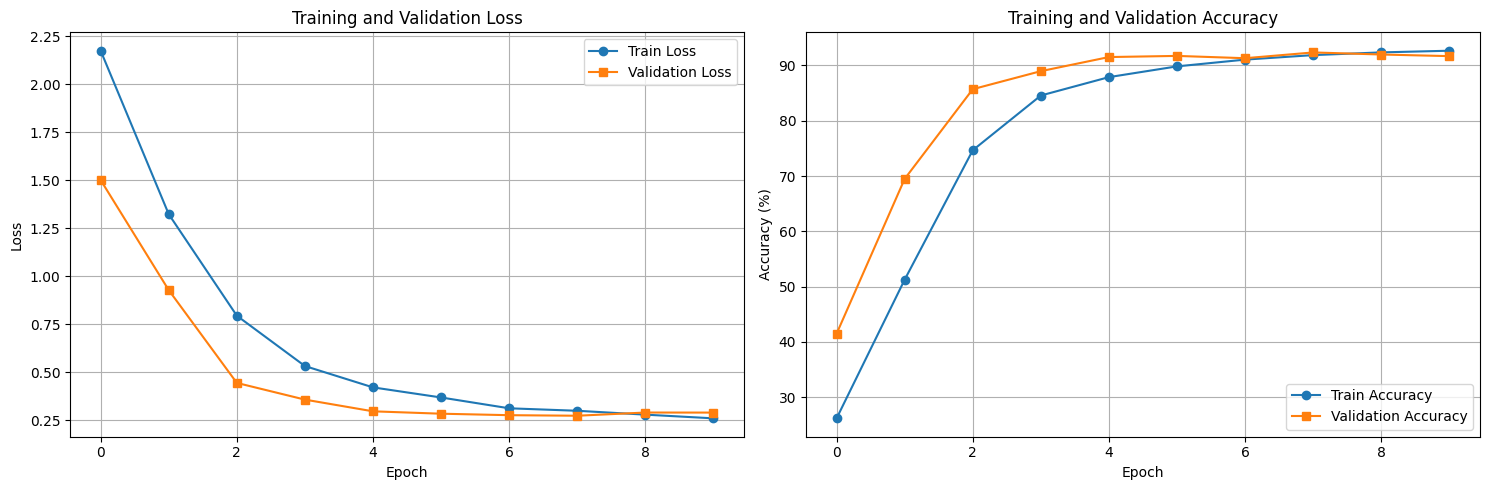

✓ Training history plot saved to: c:\Users\shifttech\Desktop\Univ_M\AV\Tp\sign_Lang\output\model\training_history.png


In [22]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Validation Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(history['val_acc'], label='Validation Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Training history plot saved to: {MODEL_DIR / 'training_history.png'}")

## 9. Load Best Model for Testing

Load the best trained model for real-time testing.

## 9.5. Load Pre-Trained Model (Skip Training)

If you already have a trained model, run this cell to load it directly without retraining.

In [10]:
# Load best model directly without retraining
import torch
from pathlib import Path

# Path to the saved model
MODEL_PATH = OUTPUT_DIR / 'model' / 'best_model.pth'

print("=" * 60)
print("LOADING PRE-TRAINED MODEL")
print("=" * 60)

if MODEL_PATH.exists():
    # Load checkpoint
    checkpoint = torch.load(MODEL_PATH, map_location=device)
    
    # Get model info
    NUM_CLASSES = checkpoint['num_classes']
    label_to_idx = checkpoint['label_to_idx']
    idx_to_label = checkpoint['idx_to_label']
    
    # Initialize model with same architecture
    model = CNN_LSTM_Model(
        num_classes=NUM_CLASSES,
        hidden_size=HIDDEN_SIZE,
        num_lstm_layers=NUM_LSTM_LAYERS,
        dropout=DROPOUT
    ).to(device)
    
    # Load trained weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"\n✓ Model loaded successfully from: {MODEL_PATH}")
    print(f"  - Validation accuracy: {checkpoint['val_acc']:.2f}%")
    print(f"  - Number of classes: {NUM_CLASSES}")
    print(f"  - Trained actions (IDs): {list(idx_to_label.values())}")
    
    # Load word mapping
    CLASS_LIST_FILE = DATA_DIR / 'wlasl_class_list.txt'
    action_id_to_word = {}
    
    if CLASS_LIST_FILE.exists():
        with open(CLASS_LIST_FILE, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    action_id = int(parts[0])
                    word = parts[1]
                    action_id_to_word[action_id] = word
        
        print(f"\n✓ Word mappings loaded from: {CLASS_LIST_FILE}")
        print(f"\n📋 Your model can recognize these signs:")
        for idx in sorted(idx_to_label.keys()):
            action_id = idx_to_label[idx]
            word = action_id_to_word.get(action_id, f"Action_{action_id}")
            print(f"  {word:20s} (Action ID: {action_id})")
    else:
        print(f"\n⚠ Warning: Word mapping file not found: {CLASS_LIST_FILE}")
        print("  Predictions will show action IDs only")
        action_id_to_word = {}
    
    print("=" * 60)
    
else:
    print(f"\n❌ ERROR: Model file not found: {MODEL_PATH}")
    print("\nPlease ensure:")
    print("  1. You have trained a model first")
    print("  2. The model file exists in the correct location")
    print("=" * 60)
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}")

LOADING PRE-TRAINED MODEL

✓ Model loaded successfully from: c:\Users\shifttech\Desktop\Univ_M\AV\Tp\sign_Lang\output\model\best_model.pth
  - Validation accuracy: 92.35%
  - Number of classes: 20
  - Trained actions (IDs): ['baby', 'eat', 'father', 'finish', 'good', 'happy', 'hear', 'house', 'important', 'love', 'mall', 'me', 'mosque', 'mother', 'normal', 'sad', 'stop', 'thanks', 'thinking', 'worry']

⚠ Warning: Word mapping file not found: c:\Users\shifttech\Desktop\Univ_M\AV\Tp\sign_Lang\data\compressed videos\wlasl_class_list.txt
  Predictions will show action IDs only


## 9.5. Load Pre-trained Model (Skip Training)

If you already have a trained model, load it directly from disk without retraining.

In [11]:
# Load best model
best_model_path = MODEL_DIR / 'best_model.pth'
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

label_to_idx = checkpoint['label_to_idx']
idx_to_label = checkpoint['idx_to_label']

print("✓ Best model loaded successfully!")
print(f"  - Validation accuracy: {checkpoint['val_acc']:.2f}%")
print(f"  - Number of classes: {checkpoint['num_classes']}")
print(f"  - Classes: {list(idx_to_label.values())}")

✓ Best model loaded successfully!
  - Validation accuracy: 92.35%
  - Number of classes: 20
  - Classes: ['baby', 'eat', 'father', 'finish', 'good', 'happy', 'hear', 'house', 'important', 'love', 'mall', 'me', 'mosque', 'mother', 'normal', 'sad', 'stop', 'thanks', 'thinking', 'worry']


## 10. Real-Time Webcam Testing

Test the trained model using your webcam for real-time sign language recognition.

**Instructions:**
- Press 'SPACE' to start recording a sign
- Perform the sign (model will capture 30 frames)
- The prediction will be displayed on screen
- Press 'Q' to quit

In [12]:
class WebcamSignRecognizer:
    """
    Real-time sign language recognizer using webcam.
    """
    
    def __init__(self, model, device, label_to_idx, idx_to_label, action_id_to_word=None,
                 sequence_length=30, img_size=128):
        self.model = model
        self.device = device
        self.label_to_idx = label_to_idx
        self.idx_to_label = idx_to_label
        self.action_id_to_word = action_id_to_word if action_id_to_word else {}
        self.sequence_length = sequence_length
        self.img_size = img_size
        
        # Initialize MediaPipe Hands
        self.mp_hands = mp.solutions.hands
        self.mp_drawing = mp.solutions.drawing_utils
        self.hands = self.mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=2,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )
        
        self.frame_buffer = []
        self.recording = False
        self.prediction = None
        self.confidence = None
        self.predicted_word = None
        
    def extract_hand_roi(self, frame, results):
        """
        Extract hand ROI from frame.
        """
        if not results.multi_hand_landmarks:
            return None
        
        hand_landmarks = results.multi_hand_landmarks[0]  # Use first hand
        h, w, _ = frame.shape
        
        # Get bounding box
        x_coords = [lm.x for lm in hand_landmarks.landmark]
        y_coords = [lm.y for lm in hand_landmarks.landmark]
        
        x_min = max(0, min(x_coords) - 0.1)
        x_max = min(1, max(x_coords) + 0.1)
        y_min = max(0, min(y_coords) - 0.1)
        y_max = min(1, max(y_coords) + 0.1)
        
        x_min_px = int(x_min * w)
        x_max_px = int(x_max * w)
        y_min_px = int(y_min * h)
        y_max_px = int(y_max * h)
        
        # Extract and resize ROI
        roi = frame[y_min_px:y_max_px, x_min_px:x_max_px]
        
        if roi.size == 0:
            return None
        
        roi = cv2.resize(roi, (self.img_size, self.img_size))
        return roi
    
    def predict_sequence(self):
        """
        Predict sign from frame buffer.
        """
        if len(self.frame_buffer) < self.sequence_length:
            return None, None, None
        
        # Prepare sequence
        sequence = []
        for frame in self.frame_buffer[-self.sequence_length:]:
            # Convert to RGB and normalize
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_normalized = frame_rgb.astype(np.float32) / 255.0
            # Convert to tensor
            frame_tensor = torch.from_numpy(frame_normalized).permute(2, 0, 1)
            sequence.append(frame_tensor)
        
        # Stack into batch
        sequence_tensor = torch.stack(sequence).unsqueeze(0).to(self.device)
        
        # Predict
        with torch.no_grad():
            outputs = self.model(sequence_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            
            predicted_label = self.idx_to_label[predicted.item()]
            confidence_score = confidence.item()
            
            # Get word name
            predicted_word = self.action_id_to_word.get(predicted_label, f"Action_{predicted_label}")
        
        return predicted_label, confidence_score, predicted_word
    
    def run(self):
        """
        Run webcam recognition.
        """
        cap = cv2.VideoCapture(0)
        
        if not cap.isOpened():
            print("Error: Could not open webcam")
            return
        
        print("\n" + "="*60)
        print("WEBCAM SIGN LANGUAGE RECOGNITION")
        print("="*60)
        print("Instructions:")
        print("  - Press SPACE to start recording a sign")
        print("  - Perform the sign (30 frames will be captured)")
        print("  - Press Q to quit")
        print("="*60)
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Flip frame horizontally for mirror effect
            frame = cv2.flip(frame, 1)
            
            # Detect hands
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = self.hands.process(frame_rgb)
            
            # Draw hand landmarks
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    self.mp_drawing.draw_landmarks(
                        frame, hand_landmarks, self.mp_hands.HAND_CONNECTIONS
                    )
            
            # Recording logic
            if self.recording:
                roi = self.extract_hand_roi(frame, results)
                
                if roi is not None:
                    self.frame_buffer.append(roi)
                    
                    # Display recording progress
                    progress = len(self.frame_buffer)
                    cv2.putText(frame, f"Recording: {progress}/{self.sequence_length}", 
                               (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                    
                    # Predict when enough frames collected
                    if len(self.frame_buffer) >= self.sequence_length:
                        self.prediction, self.confidence, self.predicted_word = self.predict_sequence()
                        self.recording = False
                        self.frame_buffer = []
            
            # Display prediction with word and confidence
            if self.prediction is not None and self.predicted_word is not None:
                confidence_percent = self.confidence * 100
                
                # Display the word in large text
                word_text = f"Sign: {self.predicted_word}"
                cv2.putText(frame, word_text, (10, 70), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)
                
                # Display confidence percentage
                conf_text = f"Confidence: {confidence_percent:.1f}%"
                cv2.putText(frame, conf_text, (10, 110), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
                
                # Display action ID (smaller text)
                action_text = f"(Action ID: {self.prediction})"
                cv2.putText(frame, action_text, (10, 145), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200, 200, 200), 2)
            
            # Display instructions
            cv2.putText(frame, "Press SPACE to record | Q to quit", 
                       (10, frame.shape[0] - 20), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            
            # Show frame
            cv2.imshow('Sign Language Recognition', frame)
            
            # Handle key presses
            key = cv2.waitKey(1) & 0xFF
            
            if key == ord('q') or key == ord('Q'):
                break
            elif key == ord(' '):  # Space key
                if not self.recording:
                    self.recording = True
                    self.frame_buffer = []
                    self.prediction = None
                    self.confidence = None
                    self.predicted_word = None
                    print("\n▶ Recording started...")
        
        cap.release()
        cv2.destroyAllWindows()
        self.hands.close()
        
        print("\n✓ Webcam session ended")


print("✓ Webcam recognizer class defined!")

✓ Webcam recognizer class defined!


## 11. Start Webcam Recognition

Run this cell to start the webcam-based sign language recognition.

In [13]:
# Create and run webcam recognizer with word mappings
recognizer = WebcamSignRecognizer(
    model=model,
    device=device,
    label_to_idx=label_to_idx,
    idx_to_label=idx_to_label,
    action_id_to_word=action_id_to_word,  # Pass word mappings
    sequence_length=SEQUENCE_LENGTH,
    img_size=IMG_SIZE
)

# Start recognition
recognizer.run()


WEBCAM SIGN LANGUAGE RECOGNITION
Instructions:
  - Press SPACE to start recording a sign
  - Perform the sign (30 frames will be captured)
  - Press Q to quit

▶ Recording started...

▶ Recording started...

▶ Recording started...

▶ Recording started...

▶ Recording started...

▶ Recording started...

▶ Recording started...

▶ Recording started...

▶ Recording started...

▶ Recording started...

▶ Recording started...

▶ Recording started...

✓ Webcam session ended


## 12. Model Summary and Next Steps

In [1]:
print("\n" + "="*60)
print("NOTEBOOK EXECUTION COMPLETE")
print("="*60)
print(f"\n✓ Model trained and saved to: {best_model_path}")
print(f"✓ Training history plot: {MODEL_DIR / 'training_history.png'}")
print(f"✓ Best validation accuracy: {best_val_acc:.2f}%")
print(f"\n📋 Model Configuration:")
print(f"  - Architecture: CNN (ResNet18) + LSTM")
print(f"  - Number of classes: {NUM_CLASSES}")
print(f"  - Sequence length: {SEQUENCE_LENGTH} frames")
print(f"  - Hidden size: {HIDDEN_SIZE}")
print(f"  - LSTM layers: {NUM_LSTM_LAYERS}")
print(f"\n🎯 Next Steps:")
print("  1. Test the model with your webcam (run cell 11)")
print("  2. Collect more training data to improve accuracy")
print("  3. Fine-tune hyperparameters (learning rate, hidden size, etc.)")
print("  4. Try different CNN backbones (ResNet50, EfficientNet, etc.)")
print("  5. Implement data augmentation for better generalization")
print("="*60)


NOTEBOOK EXECUTION COMPLETE


NameError: name 'best_model_path' is not defined